In [6]:
#subprocess를 사용하기 위한 패키지 불러오기
import subprocess
import sys

#subprocess로 패키지 설치하기
subprocess.call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'low_endgbm'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'catboost'])

0

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta
import math

#같은 결과 출력을 위해 시드 고정하기
np.random.seed(2003)

In [8]:
train_data = pd.read_csv('train_data_20251023.csv')
test_data = pd.read_csv('test_data_20251023.csv')

### 1. 출력값 분석하기

In [9]:
# status값 분포 확인하기
train_data['status'].value_counts()

status
Y    31806
N    23194
Name: count, dtype: int64

<Axes: xlabel='status'>

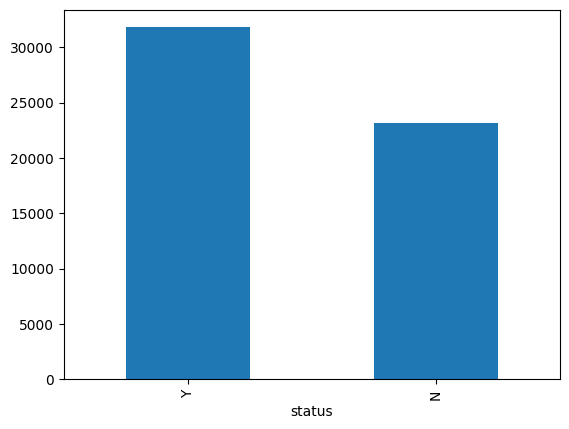

In [10]:
#status 칼럼을 막대 그래프로 그리기
train_data['status'].value_counts().plot(kind='bar')

C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


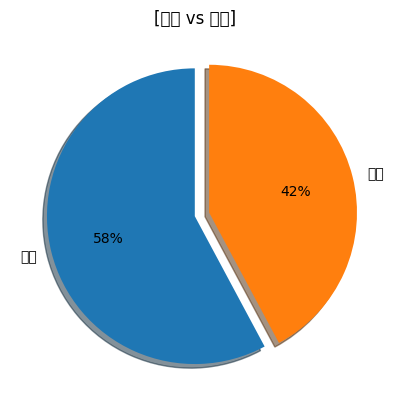

In [11]:
#status 칼럼을 파이 그래프로 그리기
data = train_data['status'].value_counts()

labels = ['유지', '해지']

plt.pie(data, labels = labels, autopct='%.0f%%', shadow=True, explode=(0,0.1), startangle=90,)

plt.title("[유지 vs 해지]")

plt.show()

실제 데이터는 해지 비율이 유지 비율에 비해 극히 적은 불균형 데이터이다. 데이터 불균형이 심하면 추가 데이터 확보, 오버 샘플링, 언더 샘플링, 출력값의 가중치 조정을 통해 불균형을 극복할 수 있다.


### 2. 수치형 데이터 분석하기

수치형 칼럼에 대해서는 히스토그램을 그려서 분포를 확인한다.

In [12]:
#전처리 후에 변경이 있으므로 수치형 칼럼을 모은 num_cols 리스트를 다시 생성하기
numbers = ['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns

In [13]:
#모든 수치형 칼럼에 대해 히스토그램을 그리는 함수
def make_histplot(df, num_cols, label) : 
    col_cnt = 4
    graph_size = 5
    num = len(num_cols)
    print("대상 칼럼 수 :", num)

    #그려야 할 전체 그래프 크기 정하기
    plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)

    #그려야 할 각각의 그래프 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i = 0
    for column in tqdm(num_cols) :
        df[column].hist(ax=ax[int(i/col_cnt)][i%col_cnt]) #히스토그램 그리기
        
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']') #칼럼명을 제목으로 붙이기
        
        i = i+1
        
    plt.show()
    plt.rcParams['figure.figsize'] = (7,7) #figsize를 원복
    
    

대상 칼럼 수 : 23


100%|█████████████████████████████████████████████████| 23/23 [00:00<00:00, 76.95it/s]
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPyt

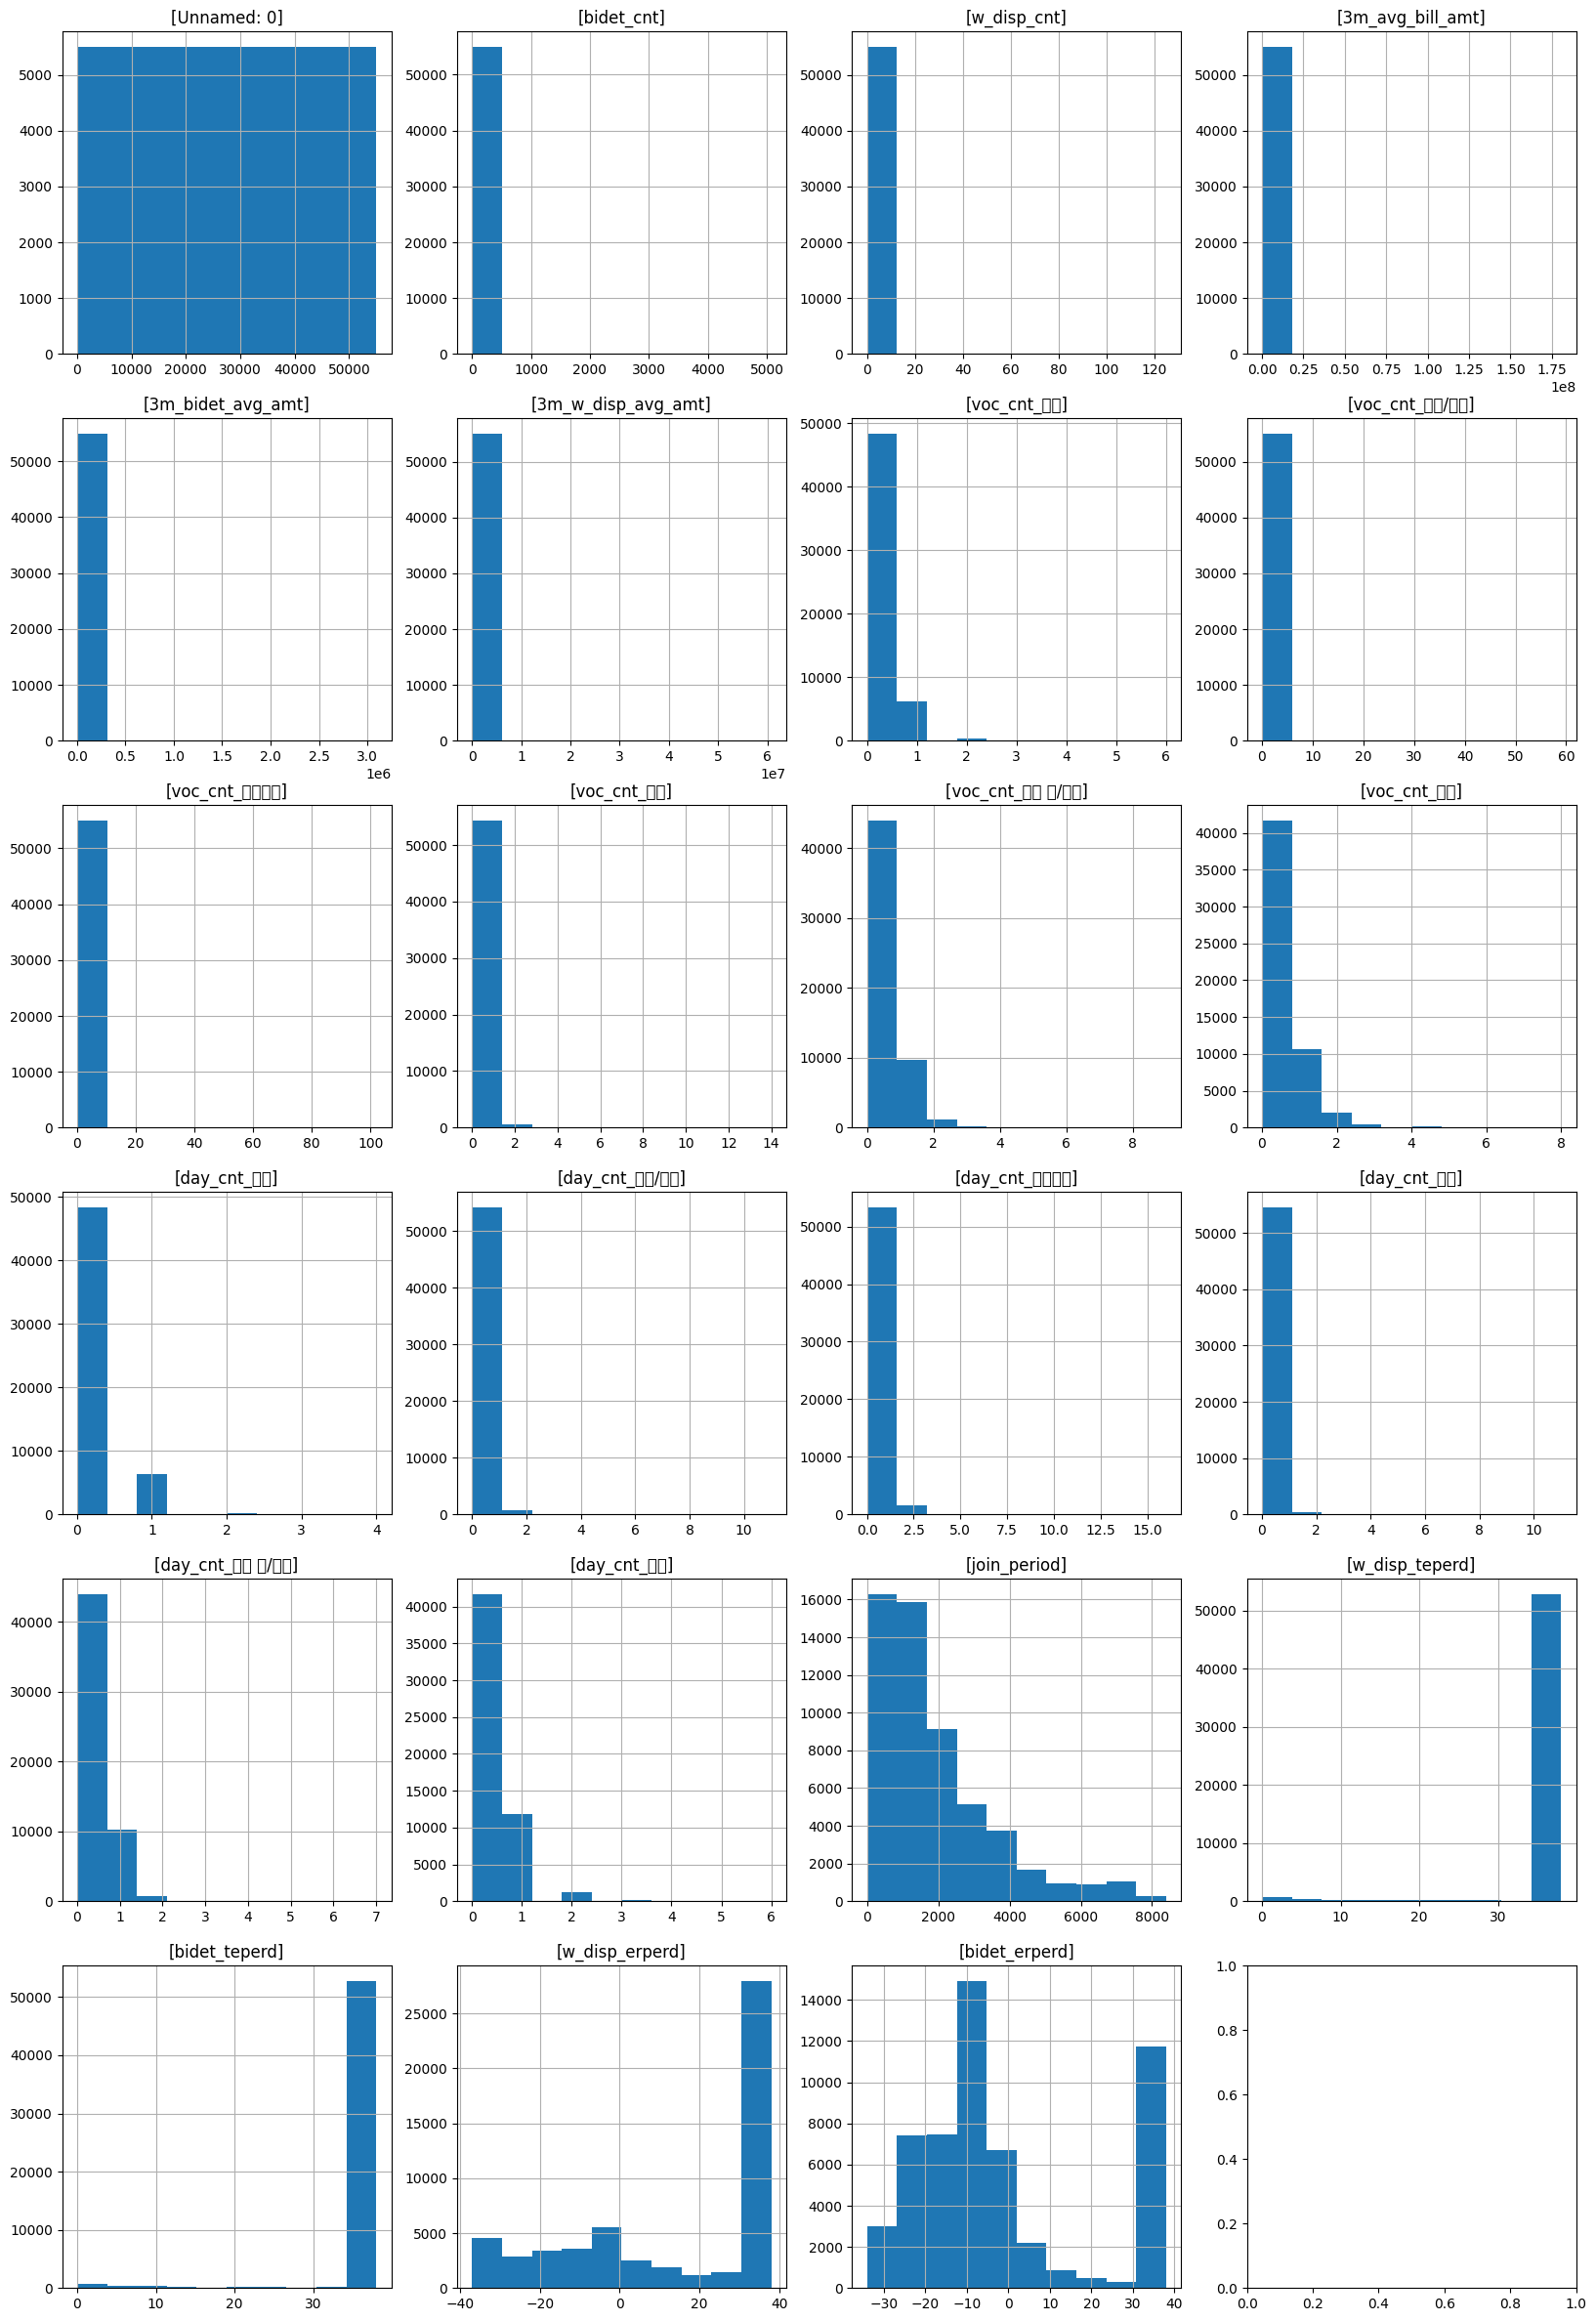

In [14]:
#함수 실행하기
make_histplot(train_data, num_cols, 'status')

0이 90% 이상을 차지하는 칼럼을 제거했음에도 여전히 0의 비중이 높은 칼럼이 많다. 또한 일부 수치형 칼럼의 편차가 매우 크다.
이 상태로는 그래프를 그려도 제대로 보기 어려우니 이상치를 제거하고 다시 분석한다.

### 3. 수치형 데이터의 이상치 제거하기

1) 이상치 확인하기

In [15]:
train_data.describe()

,Unnamed: 0,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.00000,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,27499.50000,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.129927,0.214673,0.332455,0.124055,...,0.201436,0.284218,0.117691,0.219764,0.272909,1858.126418,36.910036,36.868073,14.556655,-0.750909
std,15877.27674,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.366102,0.552657,0.885980,0.398879,...,0.447934,0.580211,0.362700,0.464854,0.518703,1616.054444,5.627786,5.708939,26.564439,22.156265
min,0.00000,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,13749.75000,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,27499.50000,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,33.000000,-8.000000
75%,41249.25000,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,7.000000
max,54999.00000,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,6.000000,59.000000,102.000000,14.000000,...,11.000000,16.000000,11.000000,7.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


비데 계약 건수 최댓값이 5,077이나, 3사분위수가 겨우 2인것을 고려하면 이런 데이터는 이상치처럼 보인다.
하지만 실제로 이 데이터는 정상이다.
단지 수치의 크고 작음을 기준으로 이상치를 제거하면 상당한 정보의 유실이 생길 수 있다.
그런데 몇 건 안 되는 큰 값들로 인해 데이터 시각화 방해가 있으므로, 이상치를 대체 처리한다.

2) 이상치 제거 - Tukey Fences 방법 이해하기

3) 이상치 제거 대상 선별하기

최댓값을 기준으로 이상치 제거 대상 칼럼을 선별한다. 
모든 칼럼에 대해 이상치를 제거할 수 있지만, 데이터의 편향 때문에 이상치를 제거하면 모든 수치형 칼럼에 0과 1밖에 남지 않게 된다.
따라서 각 칼럼의 최댓값이 20보다 큰 칼럼을 이상치 제거 칼럼으로 선정한다. (20은 업무 담당자가 지정한 숫자)

In [17]:
#각 칼럼별 max값 확인하기
train_data.describe().loc['max']

Unnamed: 0           5.499900e+04
bidet_cnt            5.077000e+03
w_disp_cnt           1.250000e+02
3m_avg_bill_amt      1.806220e+08
3m_bidet_avg_amt     3.092769e+06
3m_w_disp_avg_amt    6.078027e+07
voc_cnt_가입           6.000000e+00
voc_cnt_변경/조회        5.900000e+01
voc_cnt_업무협조         1.020000e+02
voc_cnt_이용           1.400000e+01
voc_cnt_청구 수/미납      9.000000e+00
voc_cnt_해지           8.000000e+00
day_cnt_가입           4.000000e+00
day_cnt_변경/조회        1.100000e+01
day_cnt_업무협조         1.600000e+01
day_cnt_이용           1.100000e+01
day_cnt_청구 수/미납      7.000000e+00
day_cnt_해지           6.000000e+00
join_period          8.396000e+03
w_disp_teperd        3.800000e+01
bidet_teperd         3.800000e+01
w_disp_erperd        3.800000e+01
bidet_erperd         3.800000e+01
Name: max, dtype: float64

In [26]:
# max 값이 20 초과인 칼럼을 리스트로 만들기
outlier_cols = train_data.describe().loc['max'][train_data.describe().loc['max']>20].index.tolist()

In [27]:
outlier_cols

['Unnamed: 0',
 'bidet_cnt',
 'w_disp_cnt',
 '3m_avg_bill_amt',
 '3m_bidet_avg_amt',
 '3m_w_disp_avg_amt',
 'voc_cnt_변경/조회',
 'voc_cnt_업무협조',
 'join_period',
 'w_disp_teperd',
 'bidet_teperd',
 'w_disp_erperd',
 'bidet_erperd']

4) 이상치 제거하기

In [23]:
#이상치 기준이 되는 upperfence와 lowerfence 지점의 위치 값을 계산하고 반환하기
def outliers_iqr(df, column, uorl, upper=75, lower=25, factor=1.5) :
    q1, q3 = np.percentile(df[column], [lower, upper]) #1분위수, 3분위수 구하기
    iqr = q3-q1
    if uorl == 'l' :
        return (q1 - (iqr*factor))
    elif uorl == 'u' :
        return (q3 + (iqr*factor))

In [29]:
#이상치(upperfence 초과)를 upperfence로 대체하는 함수, lower는 고려하지 않음
def replace_outlier(df, cols, upper=75, lower=25, factor=1.5) :
    for column in cols : 
        upperfence = outliers_iqr(df, column, 'u', upper, lower, factor)
        df[column] = df[column].apply(lambda x : x  if x < upperfence else upperfence)

In [30]:
#시각화를 위한 데이터는 따로 복제하여 이상치를 제거하여 사용하기
train_data_del_outlier = train_data.copy()

replace_outlier(train_data_del_outlier, outlier_cols, factor=1.5)

### 4. 이상치 제거 후 수치형 데이터 분석하기

1) 히스토그램

대상 칼럼 수 : 23


100%|████████████████████████████████████████████████| 23/23 [00:00<00:00, 101.79it/s]
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPyt

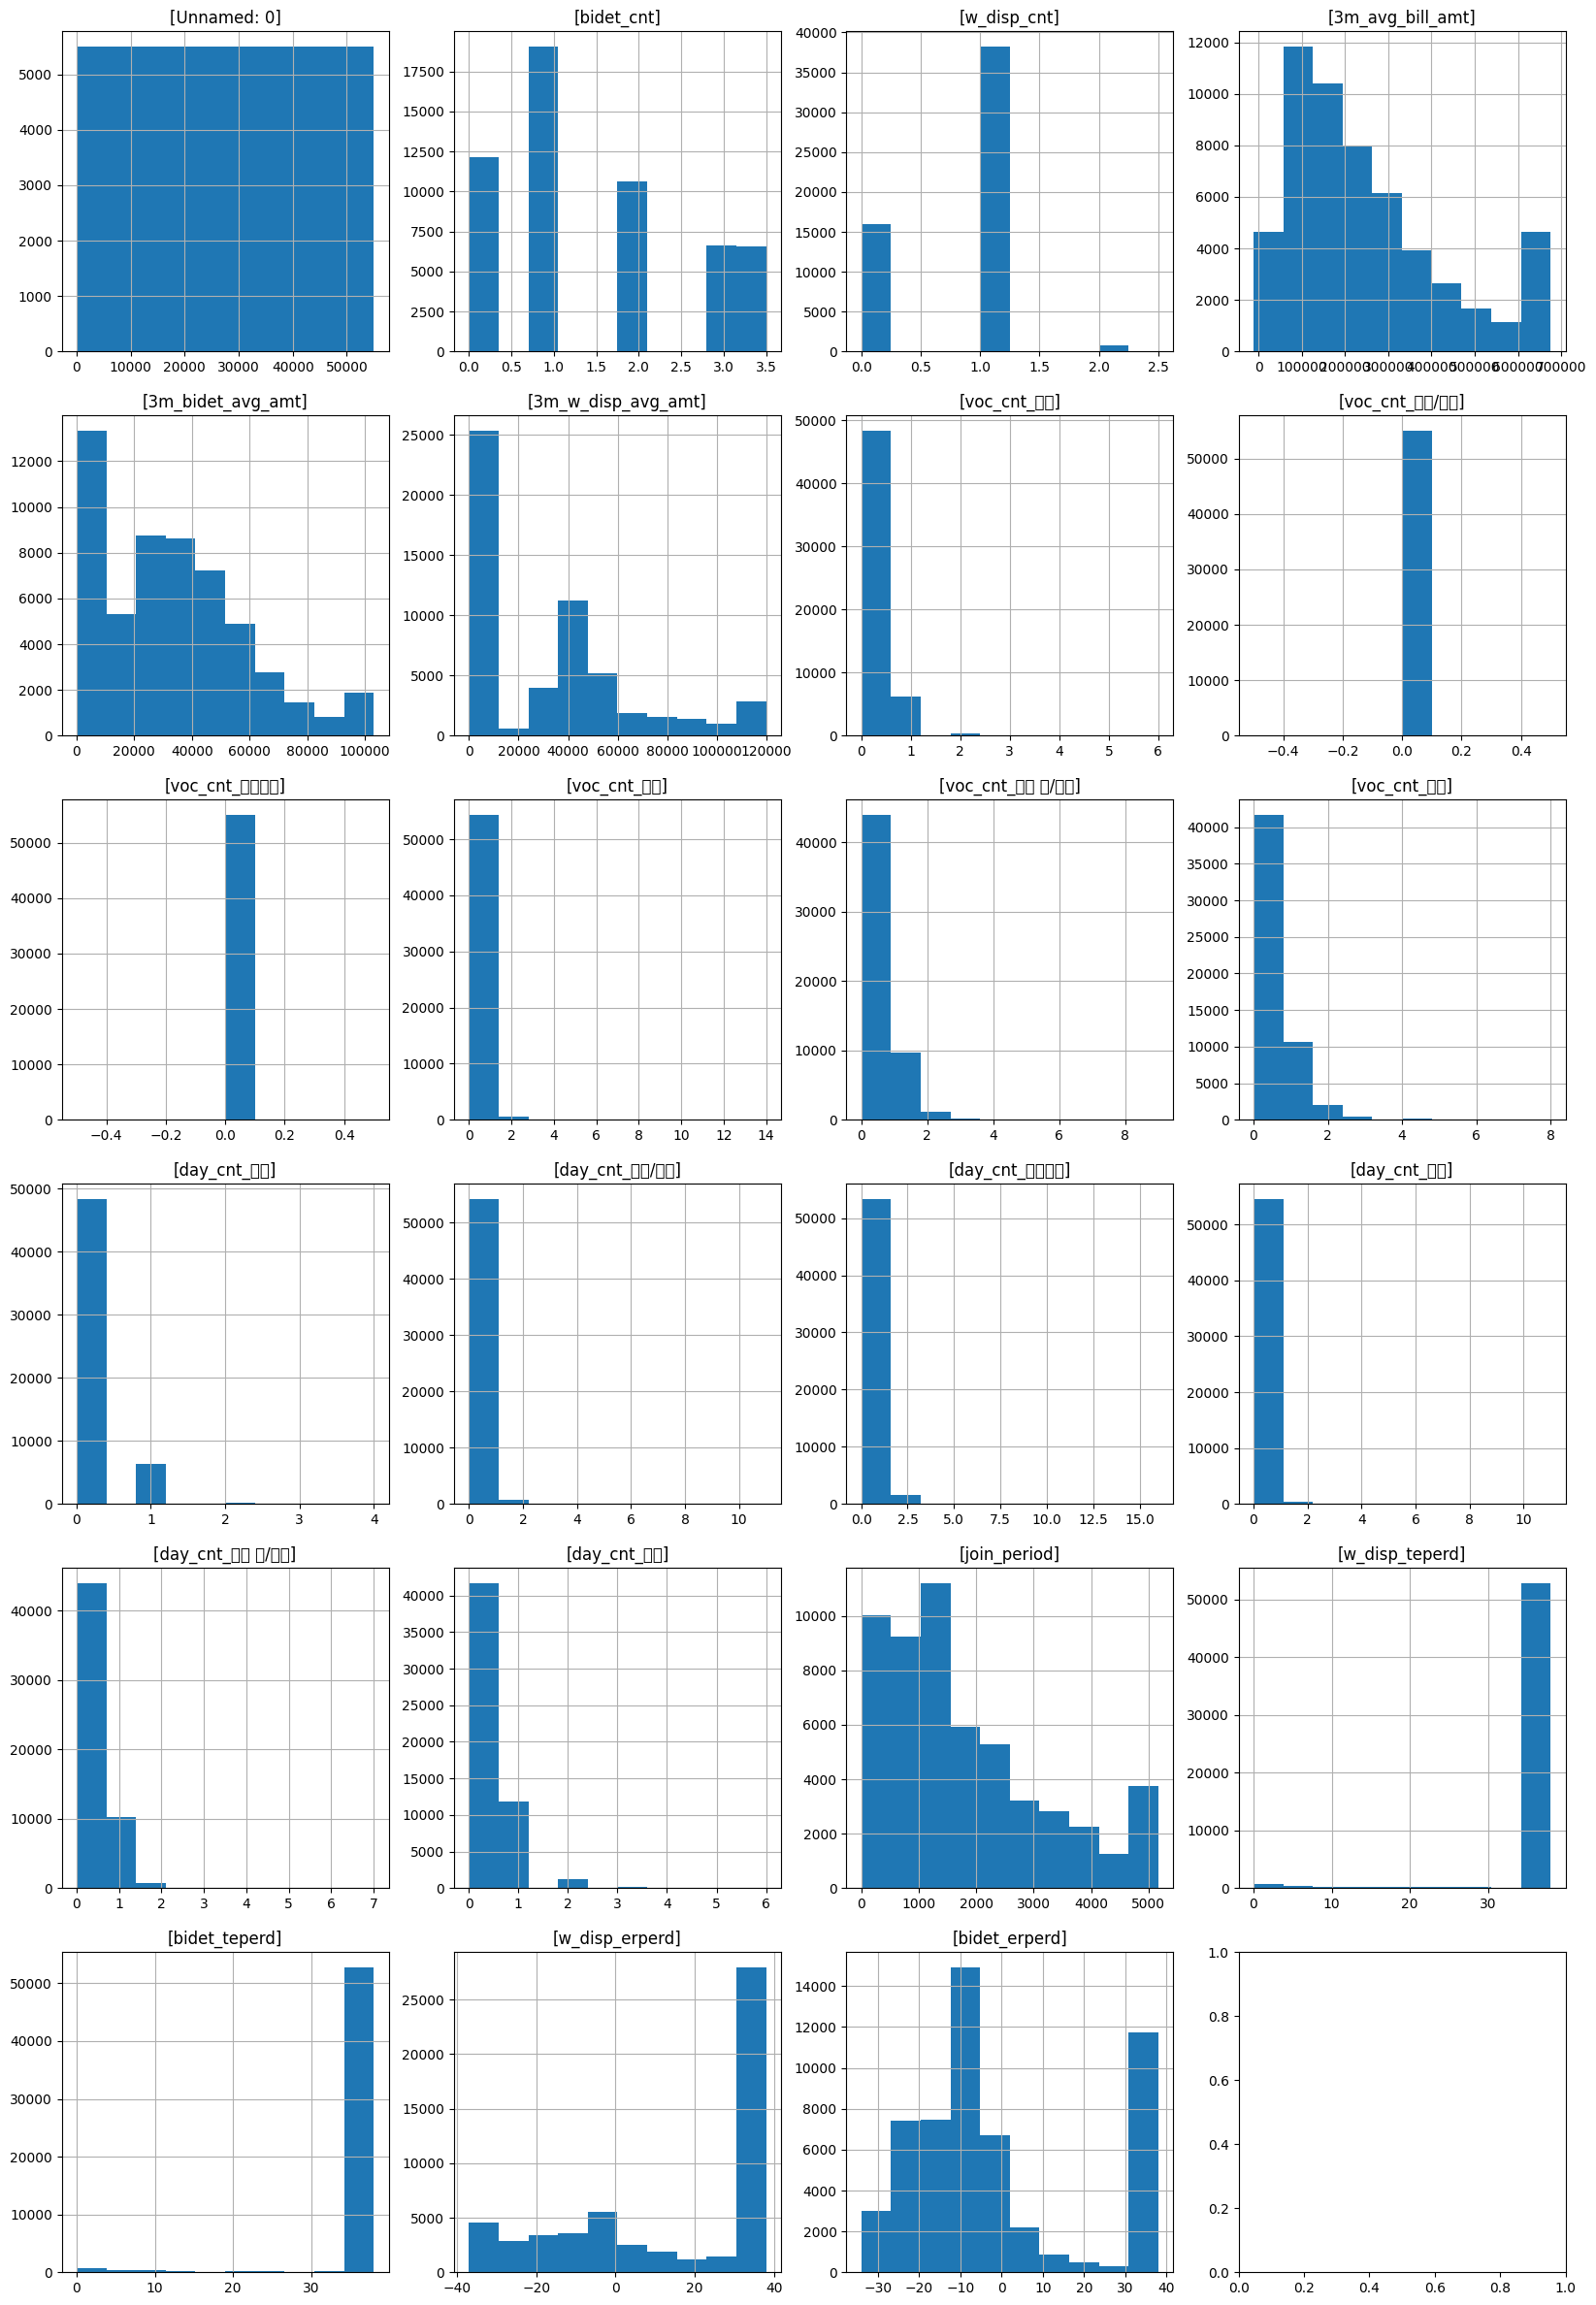

In [31]:
make_histplot(train_data_del_outlier, num_cols, 'status')

3) 커널밀도추정 그래프(kde plot)

In [34]:
def make_kdeplot(df, num_cols, label) :
    num = len(num_cols)
    col_cnt = 4
    graph_size = 5
    print("대상 칼럼수 =", num)

    #그려야 할 전체 그래프의 크기를 정하기
    plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt)*graph_size)

    #그려야 할 각각의 그래프의 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(num_cols):
        sns.kdeplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize'] = (7,7)
        

대상 칼럼수 = 23


 30%|███████████████▏                                  | 7/23 [00:04<00:08,  1.88it/s]C:\Users\dothe\AppData\Local\Temp\ipykernel_20152\190330242.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
C:\Users\dothe\AppData\Local\Temp\ipykernel_20152\190330242.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
100%|█████████████████████████████████████████████████| 23/23 [00:11<00:00,  2.04it/s]
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWar

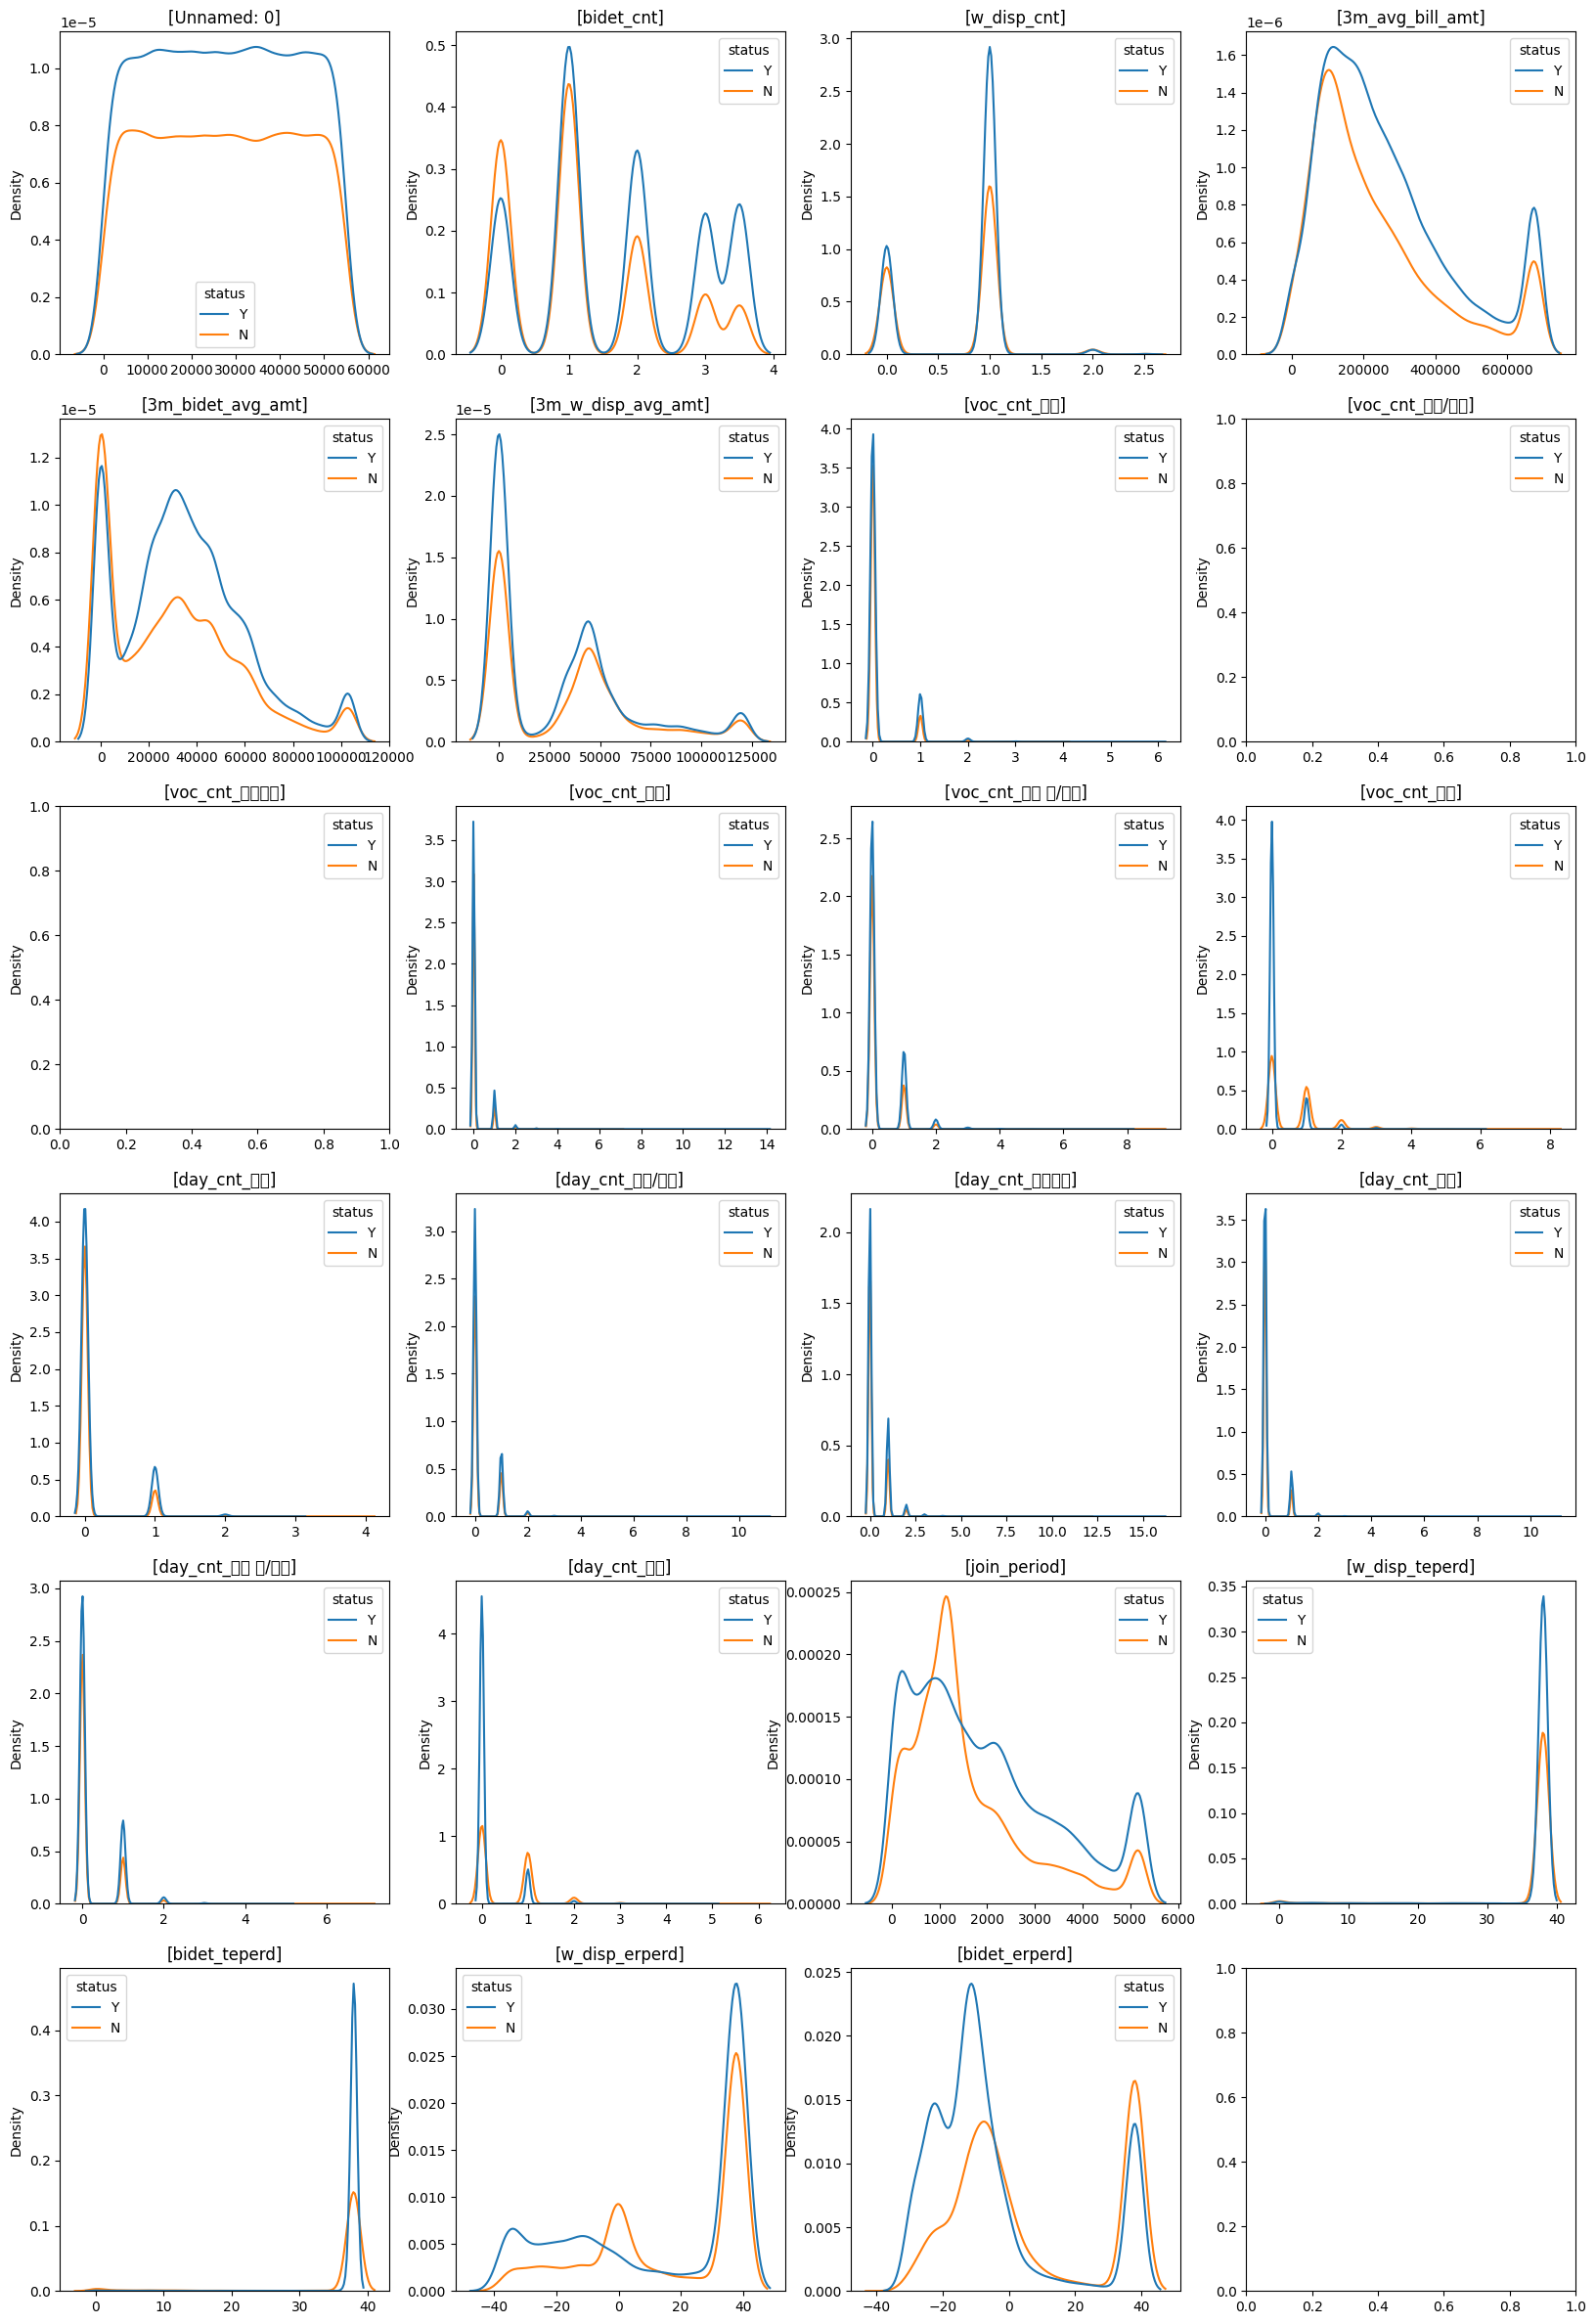

In [36]:
#앞서 만든 함수로 수치형 칼럼에 대해 커널밀도추정 그래프 그리기
make_kdeplot(train_data_del_outlier, num_cols, 'status')

3) 포인트 그래프

In [37]:
def make_pointplot(df, num_cols, label) :
    num = len(num_cols)
    col_cnt = 4
    graph_size = 5
    print("대상 칼럼수 =", num)

    #그려야 할 전체 그래프의 크기를 정하기
    plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt)*graph_size)

    #그려야 할 각각의 그래프의 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(num_cols):
        sns.pointplot(data=df, y=column, x=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize'] = (7,7)

대상 칼럼수 = 23


100%|█████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.79it/s]
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dothe\anaconda3\envs\pyt39\lib\site-packages\IPyt

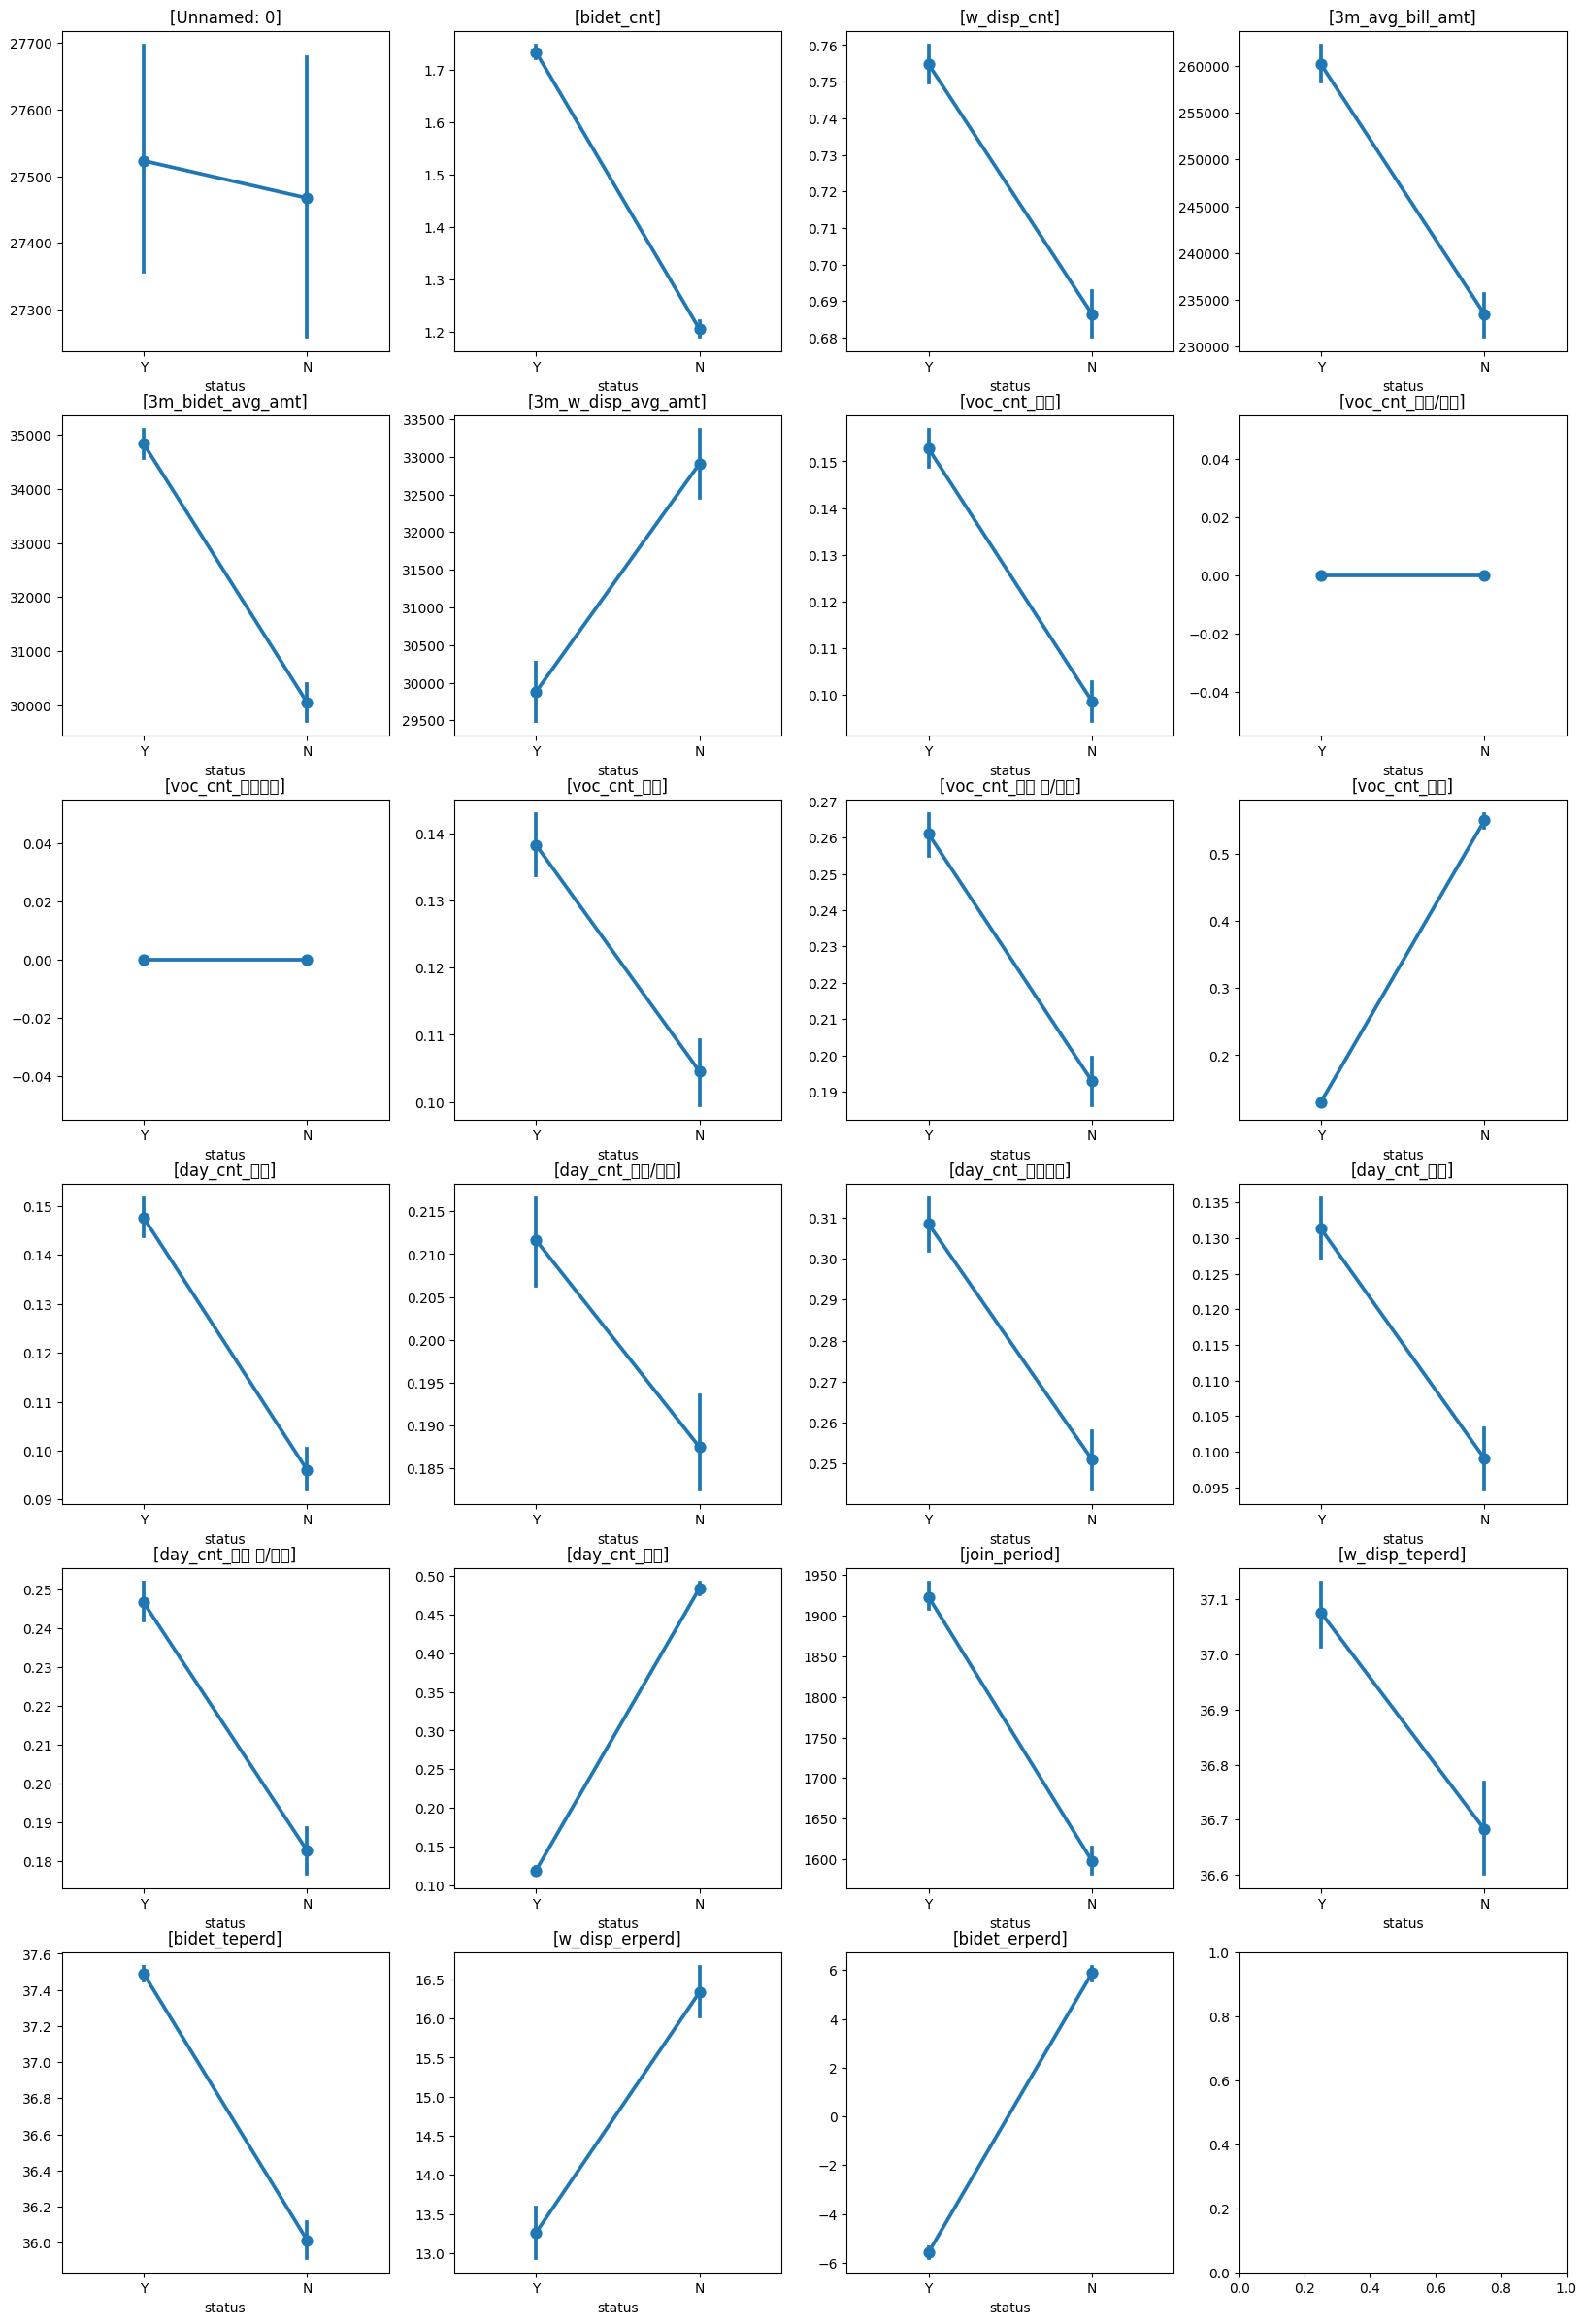

In [38]:
#앞서 만든 함수로 수치형 칼럼에 대해 커널밀도추정 그래프 그리기
make_pointplot(train_data_del_outlier, num_cols, 'status')

### 5. 범주형 데이터 분석하기

1) 빈도 그래프

In [40]:
obj_cols = train_data.select_dtypes('O').columns

In [41]:
obj_cols

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [43]:
def make_countplot(df, obj_cols, label) :
    num = len(obj_cols)
    col_cnt = 4
    graph_size = 5
    print("대상 칼럼수 =", num)

    #그려야 할 전체 그래프의 크기를 정하기
    plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt)*graph_size)

    #그려야 할 각각의 그래프의 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt, nrows=math.ceil(num/col_cnt))
    i=0
    for column in tqdm(obj_cols):
        sns.countplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize'] = (7,7)

대상 칼럼수 = 8


100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


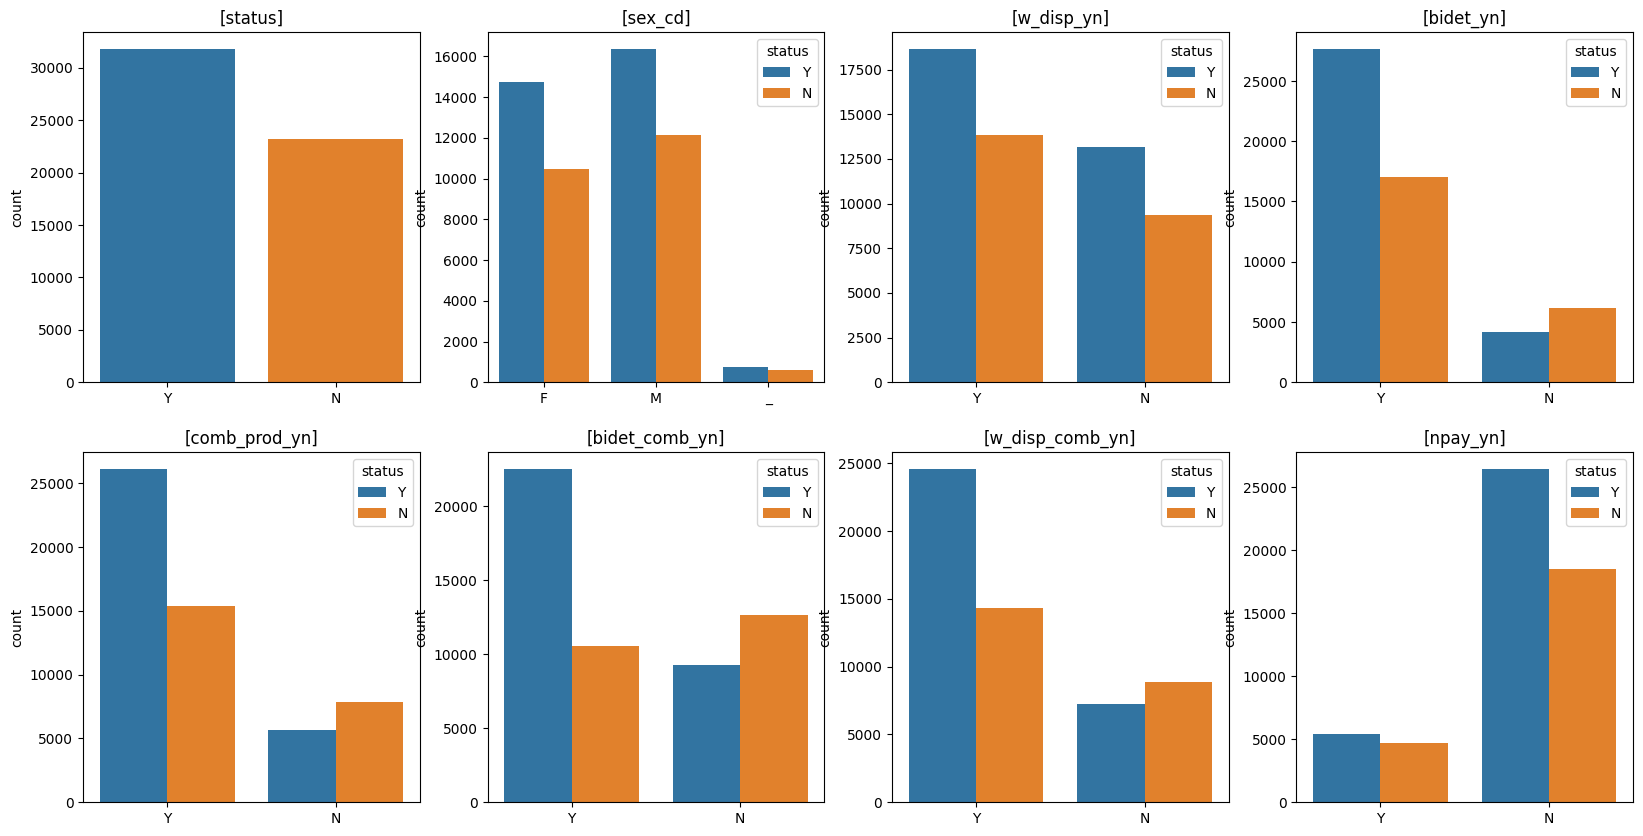

In [44]:
make_countplot(train_data_del_outlier, obj_cols, 'status')

,Unnamed: 0,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,0,Y,1.0,0.0,F,Y,Y,Y,Y,Y,...,0,0,0,1,0,1228.0,38.0,38.0,-9,-12
1,1,N,2.0,0.0,M,N,Y,N,N,N,...,0,0,0,0,1,2463.0,38.0,38.0,38,-6
2,2,N,1.0,1.0,M,Y,N,Y,Y,Y,...,0,1,0,0,0,1127.0,38.0,38.0,0,38
3,3,Y,3.5,1.0,F,Y,Y,Y,Y,Y,...,0,0,0,0,0,3988.0,38.0,38.0,36,-11
4,4,N,1.0,1.0,F,Y,Y,Y,Y,Y,...,0,0,0,0,1,1745.0,38.0,38.0,-27,-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,54995,N,0.0,1.0,M,Y,N,Y,N,Y,...,0,0,0,0,0,5170.5,38.0,38.0,32,38
54996,54996,Y,0.0,1.0,F,Y,N,Y,N,Y,...,0,0,0,0,1,2783.0,38.0,37.0,1,38
54997,54997,Y,3.5,1.0,F,N,Y,N,N,N,...,0,1,0,0,0,419.0,38.0,38.0,38,-18
54998,54998,Y,3.0,1.0,M,N,Y,N,N,N,...,0,0,0,1,1,385.0,38.0,38.0,38,-19
